In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from scipy.stats import chi2_contingency
import scipy.stats as stats
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [3]:
Dane = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data.csv', delimiter=',')

In [4]:
Dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


# Data processing

Usunięcie wiersza 'Loans that do not meet the credit policy'

In [5]:
Dane.drop(39786, axis='index', inplace = True)

In [6]:
Dane.to_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', index = False)

In [8]:
Dane = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', delimiter=',')

Usuwam zmienne o brakach co najmniej 90%

In [9]:
Braki_danych = Dane.isna().sum()
i = 0
j = 0
while i < len(Dane.columns):
    if Braki_danych[j] > 9 / 10 * len(Dane):
        Dane.drop(Dane.columns[i], axis = 1, inplace = True)
    else:
        i = i + 1
    j += 1

Usuwam niepotrzebne zmienne tekstowe

In [10]:
Dane.drop(['id', 'emp_title', 'url', 'desc', 'title', 'zip_code'], axis = 1, inplace = True)

Usuwam zmienne wybiegające w przyszłość

In [11]:
Dane.drop(['total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee'], axis = 1, inplace = True)
Dane.drop(['recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], axis = 1, inplace = True)
Dane.drop(['last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq', 'delinq_amnt', 'debt_settlement_flag'], axis = 1, inplace = True)

In [12]:
Dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42535 non-null  float64
 1   funded_amnt                 42535 non-null  float64
 2   funded_amnt_inv             42535 non-null  float64
 3   term                        42535 non-null  object 
 4   int_rate                    42535 non-null  object 
 5   installment                 42535 non-null  float64
 6   grade                       42535 non-null  object 
 7   sub_grade                   42535 non-null  object 
 8   emp_length                  41423 non-null  object 
 9   home_ownership              42535 non-null  object 
 10  annual_inc                  42531 non-null  float64
 11  verification_status         42535 non-null  object 
 12  issue_d                     42535 non-null  object 
 13  loan_status                 425

sprawdzam braki danych

In [13]:
Dane.isna().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_length                     1112
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                   29
mths_since_last_delinq        26926
open_acc                         29
pub_rec                          29
revol_bal                         0
revol_util                  

Uzupełniam braki w zmiennej mths_since_last_delinq zerami

In [14]:
Dane['mths_since_last_delinq'] = Dane['mths_since_last_delinq'].fillna(0)

Usuwam pozostałe braki danych

In [15]:
Dane.dropna(inplace = True)

Zapisanie do pliku

In [16]:
Dane.to_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', index = False)

In [17]:
Dane = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', delimiter=',')

Usuwam zmienne, u których występuje tylko jedna wartość

In [18]:
i = 0
while i < len(Dane.columns):
    if len(Dane.groupby(Dane.columns[i]).size()) == 1:
        Dane.drop(Dane.columns[i], axis = 1, inplace = True)
    else:
        i = i + 1

Dodaję zmienną loans_credit_policy

In [19]:
Dane.insert(14, 'loans_credit_policy', 0)
for i in range(0, len(Dane)):
    if Dane.loan_status[i] == 'Does not meet the credit policy. Status:Fully Paid' or Dane.loan_status[i] == 'Does not meet the credit policy. Status:Charged Off':
        Dane.loans_credit_policy[i] = 0
    else:
        Dane.loans_credit_policy[i] = 1

C:\Users\mkraw\AppData\Local\Temp/ipykernel_15996/4095776494.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.loans_credit_policy[i] = 1
C:\Users\mkraw\AppData\Local\Temp/ipykernel_15996/4095776494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.loans_credit_policy[i] = 0


Zmieniam zmienne opisowe na ilosciowe

In [20]:
Dane.term = Dane.term.replace([' 36 months', ' 60 months'], [0, 1])

In [21]:
Dane.emp_length = Dane.emp_length.replace(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [22]:
Dane['int_rate'] = Dane['int_rate'].apply(lambda x : float(x[0:-1]))
Dane['revol_util'] = Dane['revol_util'].apply(lambda x : float(x[0:-1]))

In [23]:
Dane.loan_status = Dane.loan_status.replace(['Charged Off', 'Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid'], [0, 1, 0, 1])

Przekształcam zmienną czasową

In [24]:
for i in range(0, len(Dane)):
    Dane['earliest_cr_line'][i] = int(Dane.issue_d[i][-4:]) - int(Dane.earliest_cr_line[i][-4:])

C:\Users\mkraw\AppData\Local\Temp/ipykernel_15996/1637238941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane['earliest_cr_line'][i] = int(Dane.issue_d[i][-4:]) - int(Dane.earliest_cr_line[i][-4:])


Zmieniam typ zmiennych

In [25]:
Dane[['int_rate', 'revol_util', 'emp_length']] = Dane[['int_rate', 'revol_util', 'emp_length']].astype(float)
Dane[['term', 'loan_status', 'earliest_cr_line']] = Dane[['term', 'loan_status', 'earliest_cr_line']].astype(np.int64)

In [26]:
Dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39998 entries, 0 to 39997
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               39998 non-null  float64
 1   funded_amnt             39998 non-null  float64
 2   funded_amnt_inv         39998 non-null  float64
 3   term                    39998 non-null  int64  
 4   int_rate                39998 non-null  float64
 5   installment             39998 non-null  float64
 6   grade                   39998 non-null  object 
 7   sub_grade               39998 non-null  object 
 8   emp_length              39998 non-null  float64
 9   home_ownership          39998 non-null  object 
 10  annual_inc              39998 non-null  float64
 11  verification_status     39998 non-null  object 
 12  issue_d                 39998 non-null  object 
 13  loan_status             39998 non-null  int64  
 14  loans_credit_policy     39998 non-null

# EDA

Sprawdzam wpływ niektórych zmiennych na prawdopodobieństwo wypłacenia zobowiązania

C:\Users\mkraw\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


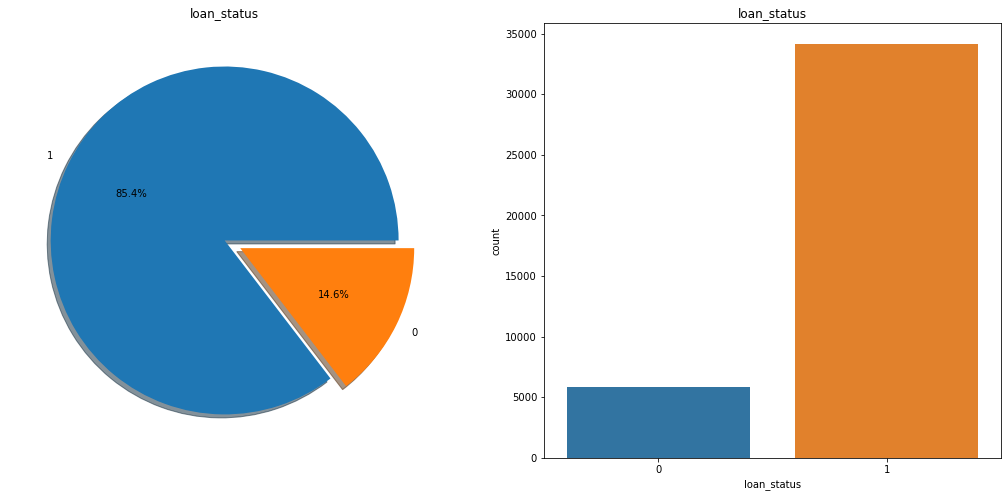

In [27]:
f, ax = plt.subplots(1,2,figsize = (18,8))
Dane['loan_status'].value_counts().plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
ax[0].set_title('loan_status')
ax[0].set_ylabel('')
sns.countplot('loan_status', data = Dane, ax = ax[1])
ax[1].set_title('loan_status')
plt.show()

Z danych wynika, że spośród 40 003 pożyczkobiorców ponad 85% z nich spłaciła swoje kredyty

Dodaję cztery funkcje, które pomogą w dalszej analizie

In [28]:
def segmended_bar(col1, col2='loan_status'):
    data1 = Dane[col1][Dane[col1].isin(
        Dane[col1].value_counts()[Dane[col1].value_counts() > 20].index)]
    if len(data1) == 0: data1 = df[col1]
    cross_tab = pd.crosstab(index=data1.sort_values(), columns=Dane[col2],
                            normalize="index")
    cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Blues')

    plt.legend(loc="upper left", ncol=2)
    plt.xlabel(col1)
    plt.ylabel("%Chance")
    plt.axhline(y=0.146, color='y', linestyle='-')
    plt.show()

In [29]:
def chance_of_paid(col, x):
    grade = pd.concat([Dane.groupby(col)[col].count().rename(index='sum'),
                       Dane[Dane['loan_status'] == 1].groupby(col)[
                           col].count().rename(index='Paid'),
                       Dane[Dane['loan_status'] == 0].groupby(col)[
                           col].count().rename(index='UnPaid')],
                      axis=1).reset_index()
    grade = grade[grade['sum'] > 20]
    grade['%Paid'] = round(grade['Paid'] / grade['sum'] * 100, 2)
    display(grade)
    sns.catplot(height=5, aspect=x / 5, data=grade, x=col, y="%Paid", s=10)
    plt.xticks(rotation=45)

In [30]:
def test_chi_kwadrat(c):
    stat, p, dof, expected = chi2_contingency(c)
    alfa = 0.05
    print("p-value wynosi " + str(p))
    if p <= alfa:
        print('Zmienne zależne (odrzucenie H0)')
    else:
        print('Zmienne niezależne (utrzymanie H0)')

In [31]:
def test_t_studenta(col1, col2):
    p = stats.ttest_ind(col1, col2)[1]
    alfa = 0.05
    print("p-value wynosi " + str(p))
    if p <= alfa:
        print('Zmienne zależne (odrzucenie H0)')
    else:
        print('Zmienne niezależne (utrzymanie H0)')

,fico_range_low,sum,Paid,UnPaid,%Paid
0,640.0,35,27,8.0,77.14
1,645.0,45,31,14.0,68.89
2,650.0,57,40,17.0,70.18
3,655.0,59,43,16.0,72.88
4,660.0,1475,1145,330.0,77.63
5,665.0,1714,1295,419.0,75.55
6,670.0,1747,1363,384.0,78.02
7,675.0,1899,1544,355.0,81.31
8,680.0,2094,1703,391.0,81.33
9,685.0,2179,1804,375.0,82.79


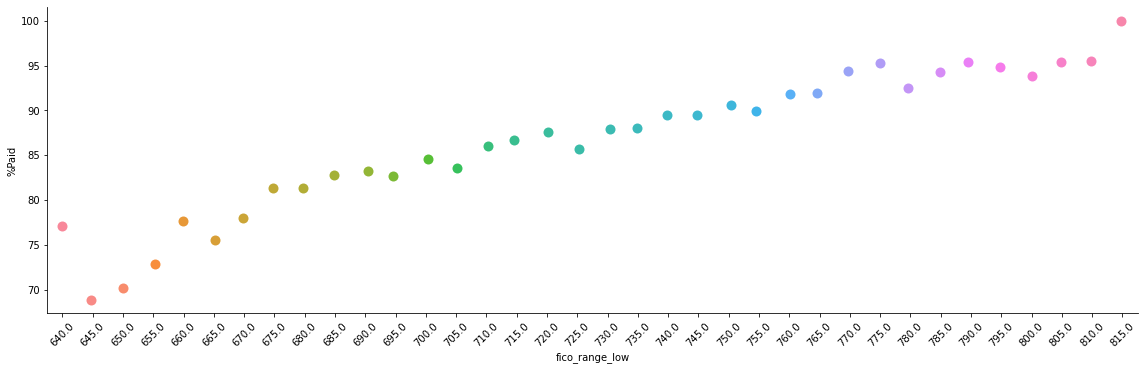

In [32]:
chance_of_paid('fico_range_low', 16)

In [33]:
fico_1 = Dane[Dane['loan_status'] == 1].fico_range_low
fico_0 = Dane[Dane['loan_status'] == 0].fico_range_low
test_t_studenta(fico_1, fico_0)

p-value wynosi 3.543918650542443e-167
Zmienne zależne (odrzucenie H0)


Z powyższego wykresu widać, że wraz ze wzrostem wartości fico rośnie prawdopodobieństwo spłacenia pożyczki. Potwierdza to test t-studenta. Wartość p bliska zeru pozwala na odrzucenie hipotezy zerowej na rzecz hipotezy alternatywnej

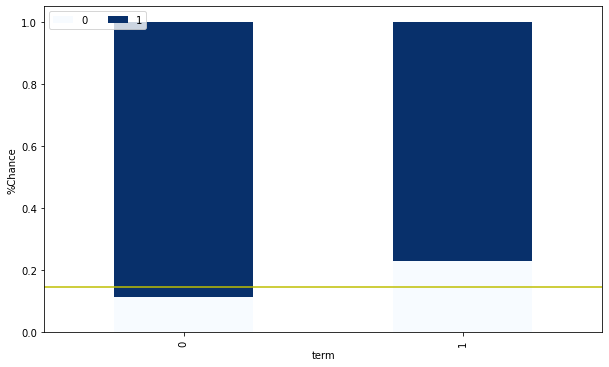

In [34]:
segmended_bar('term')

In [35]:
Term = pd.crosstab(Dane['term'], Dane['loan_status'])

In [36]:
test_chi_kwadrat(Term)

p-value wynosi 2.984432561150558e-185
Zmienne zależne (odrzucenie H0)


Na podstawie powyższego histogramu można stwierdzić, że długość spłaty pożyczki wpływa na prawdopodobieństwo spłacenia pożyczki. Prawdopodobieństwo spłacenia pożyczki wziętej na 36 miesięcy jest większe niż na 60 miesięcy. Te wnioski potwierdza test chi^2, w którym odrzucono hipotezę zerową (analizowane grupy nie różnią się pod względem prawdopobieństwa spłaccenia pożyczki) na rzecz hipotezy alternatywnej (istnieje różnica pod względem wypłacalności).

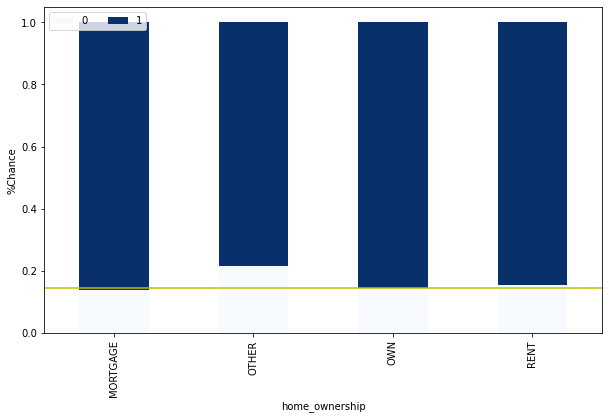

In [37]:
segmended_bar('home_ownership')

In [38]:
Home_1 = pd.crosstab(Dane['home_ownership'], Dane['loan_status'])
Home_1.drop(['OWN', 'RENT'], axis = 'index', inplace = True)
Home_1

loan_status,0,1
home_ownership,,
MORTGAGE,2464,15545
OTHER,29,105


In [39]:
Home_2 = pd.crosstab(Dane['home_ownership'], Dane['loan_status'])
Home_2.drop(['OTHER', 'RENT'], axis = 'index', inplace = True)
Home_2

loan_status,0,1
home_ownership,,
MORTGAGE,2464,15545
OWN,421,2489


In [40]:
Home_3 = pd.crosstab(Dane['home_ownership'], Dane['loan_status'])
Home_3.drop(['OTHER', 'OWN'], axis = 'index', inplace = True)
Home_3

loan_status,0,1
home_ownership,,
MORTGAGE,2464,15545
RENT,2921,16024


In [41]:
test_chi_kwadrat(Home_1)
print('\n')
test_chi_kwadrat(Home_2)
print('\n')
test_chi_kwadrat(Home_3)

p-value wynosi 0.011068859546225693
Zmienne zależne (odrzucenie H0)


p-value wynosi 0.26658215874268565
Zmienne niezależne (utrzymanie H0)


p-value wynosi 2.4328806765318696e-06
Zmienne zależne (odrzucenie H0)


Pożyczkobiorcy mający hipotekę częściej spłacają swoje pożyczki w porównaniu do pozostałych grup. Test chi^2 wykazał, że istnienie statystyczna różnica w wypłacalności między grupą MORTGAGE a grupami OTHER i RENT. Natomiast między grupami MORTGAGE i OWN nie ma statystycznej różnicy w wypłacalności pożyczek

,annual_inc,sum,Paid,UnPaid,%Paid
18,9600.0,21,15.0,6.0,71.43
40,12000.0,71,53.0,18.0,74.65
68,14400.0,87,66.0,21.0,75.86
76,15000.0,60,45.0,15.0,75.00
87,15600.0,29,27.0,2.0,93.10
...,...,...,...,...,...
5056,210000.0,21,20.0,1.0,95.24
5073,225000.0,34,30.0,4.0,88.24
5091,240000.0,26,23.0,3.0,88.46
5105,250000.0,50,44.0,6.0,88.00


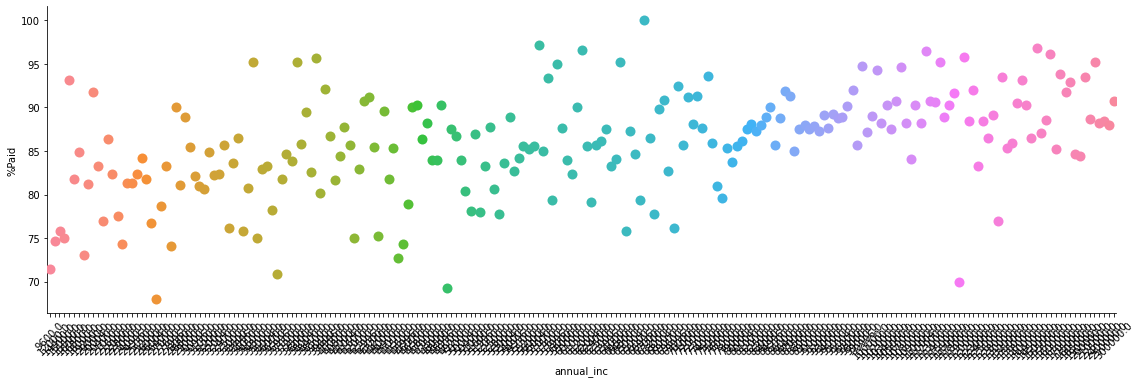

In [42]:
chance_of_paid('annual_inc', 16)

In [43]:
annual_inc_1 = Dane[Dane['loan_status'] == 1].annual_inc
annual_inc_0 = Dane[Dane['loan_status'] == 0].annual_inc
test_t_studenta(annual_inc_1, annual_inc_0)

p-value wynosi 6.092313148917989e-15
Zmienne zależne (odrzucenie H0)


Na podstawie powyższego wykresu widać niewielką tendencję wzrostową między rocznymi dochodami a prawdopodobieństwem spłacenia pożyczki. W teście t-studenta odrzuciłem hipotezę zerową na rzecz hipotezy alternatywnej co potwierdza wniosek o istotności wielkości dochodów na spłacalność zaciągniętej pożyczki

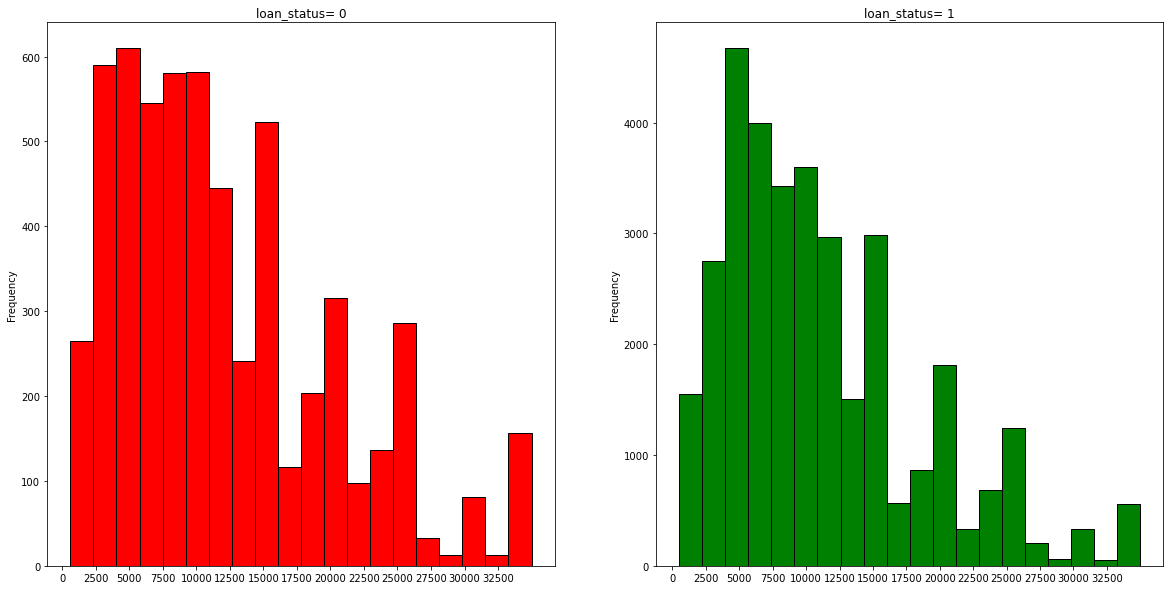

In [44]:
f,ax=plt.subplots(1,2,figsize=(20,10))
Dane[Dane['loan_status']==0].loan_amnt.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('loan_status= 0')
x1=list(range(0,35000,2500))
ax[0].set_xticks(x1)
Dane[Dane['loan_status']==1].loan_amnt.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('loan_status= 1')
x2=list(range(0,35000,2500))
ax[1].set_xticks(x2)
plt.show()

,loan_amnt,sum,Paid,UnPaid,%Paid
4,1000.0,279,243.0,36.0,87.10
11,1200.0,130,109.0,21.0,83.85
18,1400.0,48,40.0,8.0,83.33
22,1500.0,296,253.0,43.0,85.47
25,1600.0,95,81.0,14.0,85.26
...,...,...,...,...,...
801,27000.0,24,19.0,5.0,79.17
813,28000.0,148,134.0,14.0,90.54
834,30000.0,378,306.0,72.0,80.95
855,32000.0,32,26.0,6.0,81.25


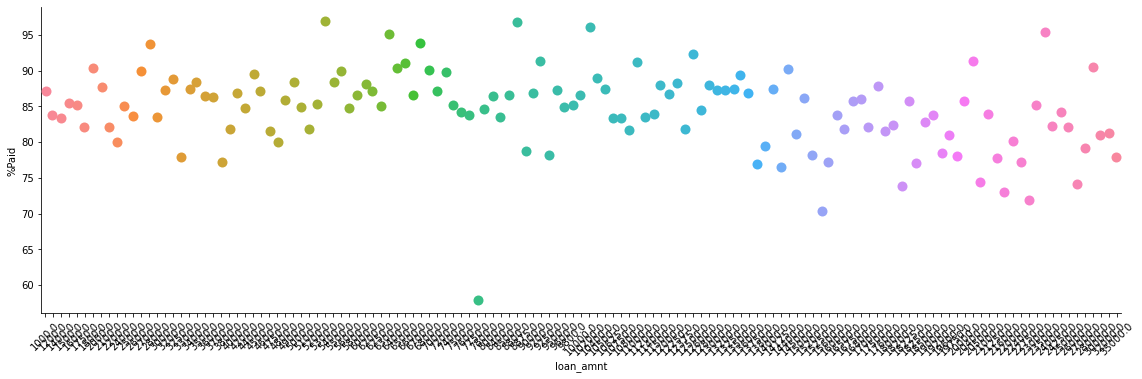

In [45]:
chance_of_paid('loan_amnt', 16)

In [46]:
loan_amnt_1 = Dane[Dane['loan_status'] == 1].loan_amnt
loan_amnt_0 = Dane[Dane['loan_status'] == 0].loan_amnt
test_t_studenta(loan_amnt_1, loan_amnt_0)

p-value wynosi 2.1054119073182865e-19
Zmienne zależne (odrzucenie H0)


Na podstawie powyższego wykresu nie można stwierdzić czy wielkość pożyczki wpływa na prawdopodobieństwo spłacenia pożyczki. Jednak według testu t-studenta, w którym hipoteza zerowa została odrzucona na rzecz hipotezy alternatywnej, istnieje statystyczna zależność między wielkością pożyczki a prawdopodobieństwem jej spłacenia

<AxesSubplot:>

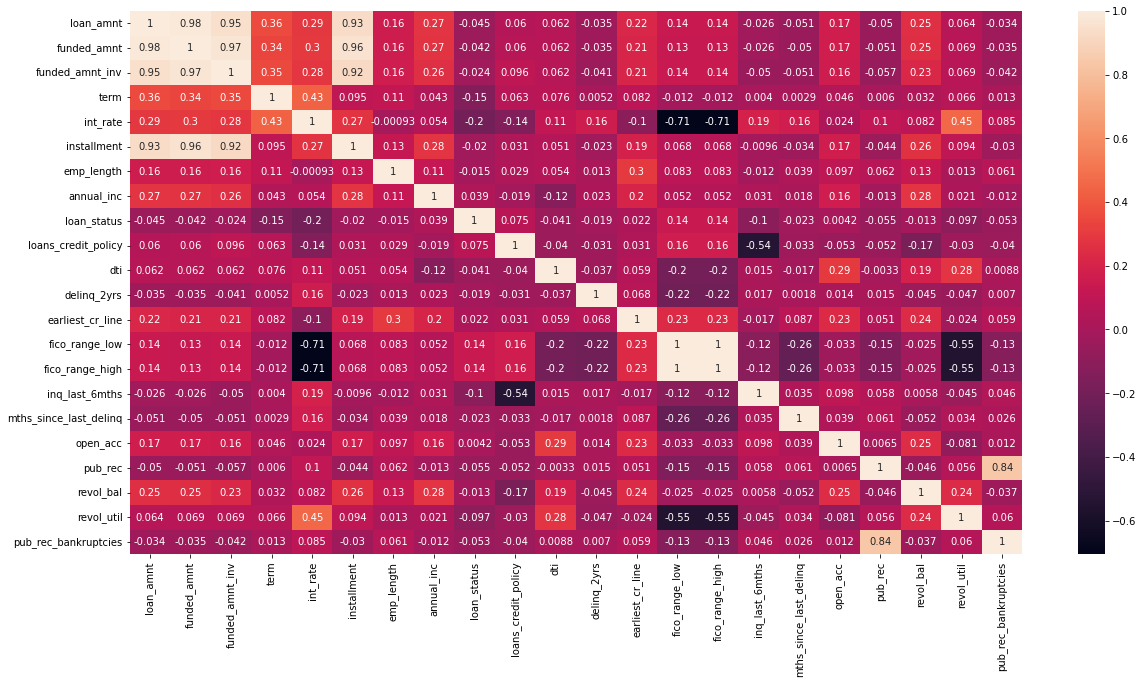

In [47]:
plt.figure(figsize = (20,10))       
sns.heatmap(Dane.corr(),annot = True)

Na podstawie macierzy korelacji można stwierdzić, że loan_status jest słabo skorelowana z każdą z pozostałych zmiennych. Najbardziej skorelowane zmienne z loan_status to int_rate (oprocentowanie), dwie zmienne fico_range oraz term (wiek kredytowy).

# Future engineering

Dodaję zmienne binarne

In [48]:
Dane = pd.get_dummies(Dane, columns=['grade'])
Dane = pd.get_dummies(Dane, columns=['home_ownership'])
Dane = pd.get_dummies(Dane, columns=['verification_status'])

Dodaję dwie zmienne:
    1. month_inc - miesięczny dochód
    2. installment/month_inc - stosunek miesięcznej płatności do miesięcznego dochodu wyrażony w procentach

In [49]:
Dane['month_inc'] = Dane.annual_inc / 12

In [50]:
Dane['installment/month_inc'] = Dane.installment / Dane.month_inc * 100

Przydzielam zmienne objaśniające i zmienną objaśnianą

In [51]:
X = Dane.drop(['loan_status', 'sub_grade', 'issue_d', 'purpose', 'addr_state', 'fico_range_high'], axis = 1)
Y = Dane['loan_status']

Standaryzuję zmienne

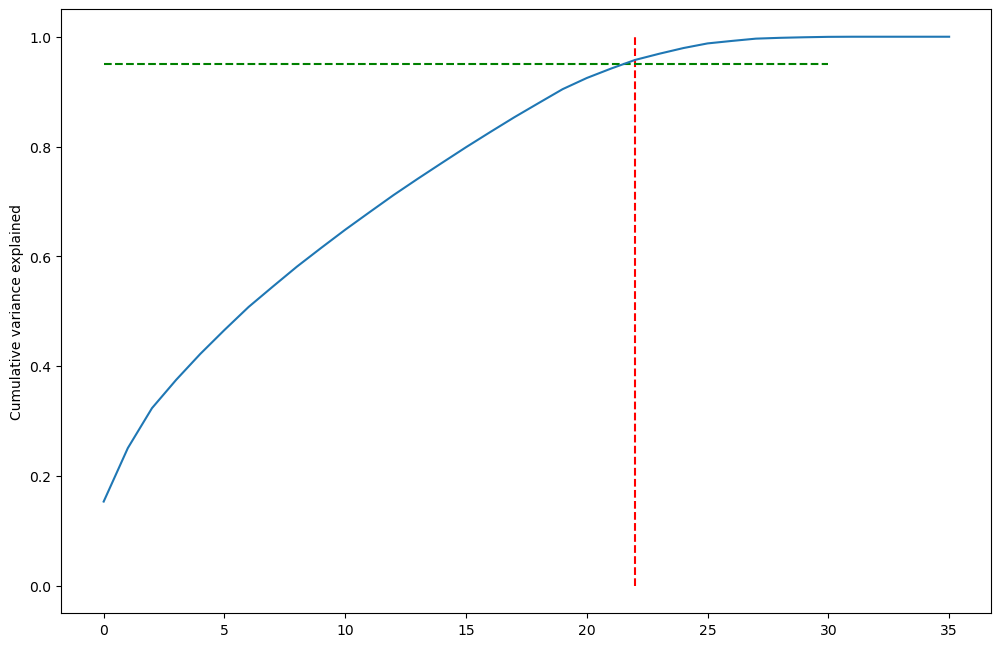

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(random_state = 42)
pca.fit(X_scaled)
pca.components_[0]
pca.explained_variance_ratio_
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize = [12,8], dpi = 100)
plt.vlines(x=22, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [53]:
pca_final = IncrementalPCA(n_components=22)
X_pca_final = pca_final.fit_transform(X_scaled)

# Klasteryzacja danych

Klasteryzacja KMeans

In [54]:
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Dla {0} klastrów wskaźnik silhouette wynosi {1}".format(i, silhouette_avg))

Dla 2 klastrów wskaźnik silhouette wynosi 0.26555329080738543
Dla 3 klastrów wskaźnik silhouette wynosi -0.003638911155200859
Dla 4 klastrów wskaźnik silhouette wynosi -0.042392361463019314
Dla 5 klastrów wskaźnik silhouette wynosi -0.05577793652605577
Dla 6 klastrów wskaźnik silhouette wynosi -0.050399141460263926
Dla 7 klastrów wskaźnik silhouette wynosi -0.08806346255672536
Dla 8 klastrów wskaźnik silhouette wynosi -0.08842242521247233
Dla 9 klastrów wskaźnik silhouette wynosi -0.08815997484688559
Dla 10 klastrów wskaźnik silhouette wynosi -0.13000073563739495


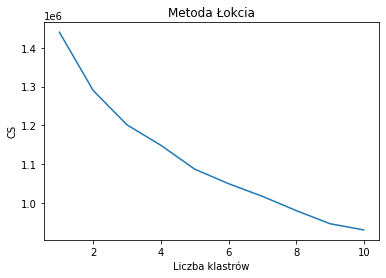

In [55]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
    kmeans.fit(X_scaled)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('Metoda Łokcia')
plt.xlabel('Liczba klastrów')
plt.ylabel('CS')
plt.show()

Na podstawie metody łokcia nie da się stwierdzić jednoznacznie najlepszej liczby klastrów. Dlatego wykorzystałem wskaźnik silhouette, u którego najlepszą wartość miał przy podziale na dwa klastry.

In [56]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
kmeans.fit(X_scaled)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [58]:
Dane['kmeans_labels'] = kmeans.labels_

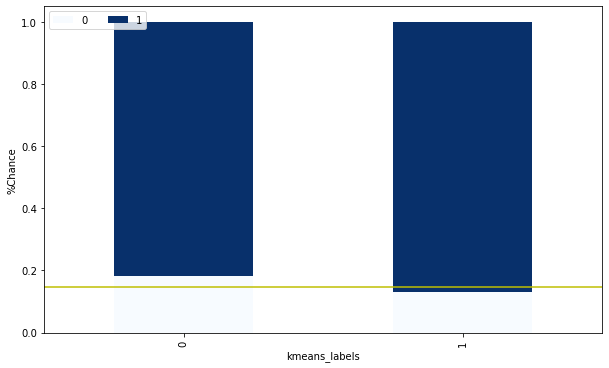

In [59]:
segmended_bar('kmeans_labels')

In [60]:
Dane.groupby('kmeans_labels').size()

kmeans_labels
0    12161
1    27837
dtype: int64

In [61]:
k = pd.crosstab(Dane['kmeans_labels'], Dane['loan_status'])
test_chi_kwadrat(k)

p-value wynosi 1.238791455360263e-42
Zmienne zależne (odrzucenie H0)


Na podstawie testu chi kwadrat można stwierdzić, że obydwa klastry różnią się pod względem prawdopodibieństwa spłacenia pożyczki. Mianowicie pożyczkobiorcy należący do grupy 1 częściej spłacają swoje pożyczki.

Klasteryzacja hierarchiczna

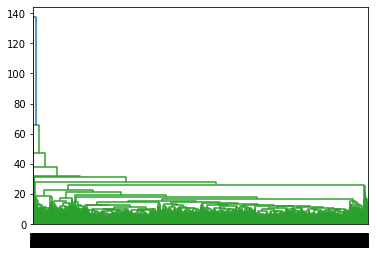

In [64]:
cl_mergings = linkage(X_scaled, method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.show()

In [65]:
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=2).reshape(-1, )
cl_cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
Dane['dendrogram_labels'] = cl_cluster_labels

In [67]:
Dane.groupby('dendrogram_labels').size()

dendrogram_labels
0    39996
1        2
dtype: int64

Klasteryzacja hierarchiczna również podzieliła dane na dwa klastry. Jednakże jedynie dwa rekordy zostały przydzielone do jednej z grup.

Klasteryzacja DBSCAN

In [71]:
A = []
B = []
C = []
for i in np.linspace(0.5,6,12):
    db = DBSCAN(eps=i, min_samples=100).fit(X_scaled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    sum = 0
    for t in labels:
        if t == -1: 
            sum = sum + 1
    C.append(sum)
    A.append(i)
    B.append(int(n_clusters_))

<AxesSubplot:xlabel='epsilon'>

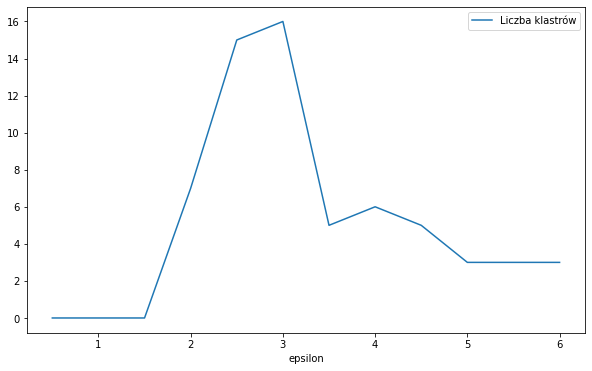

In [72]:
results = pd.DataFrame([A,B,C]).T
results.columns = ['epsilon','Liczba klastrów','Liczba wartości odstających']
results.plot(x='epsilon',y='Liczba klastrów',figsize=(10,6))

Powyższy wykres pokazuje jaka jest optymalna liczba klastrów dla różnych wartośi epsilon

<AxesSubplot:xlabel='epsilon'>

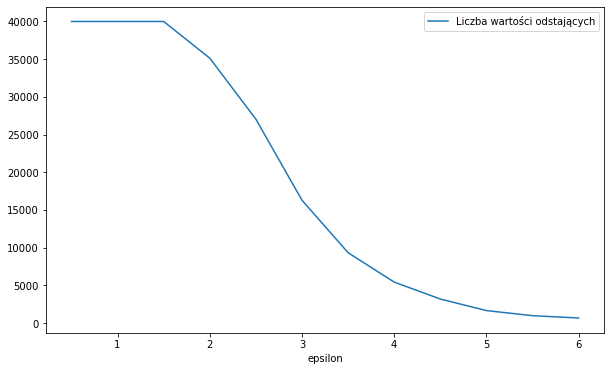

In [73]:
results.plot(x='epsilon',y='Liczba wartości odstających',figsize=(10,6))

Z kolei ten wykres pokazuje ile recordów algorytm wskaże jako wartości odstające dla różnych wartośi epsilon

Z powyższych wykresów wynika, że najlepjej ustawić wartość epsilon jako 6, ponieważ liczba grup nie będzie duża oraz algorytm przydzieli stosunkową niewielką liczbę recordów jako wartości odstające

In [74]:
db = DBSCAN(eps=6, min_samples=100).fit(X_scaled)
db.fit(X_scaled)

DBSCAN(eps=6, min_samples=100)

In [75]:
Dane['dbscan_labels'] = db.labels_

In [76]:
Dane.groupby('dbscan_labels').size()

dbscan_labels
-1      662
 0    38021
 1     1023
 2      292
dtype: int64

Klasteryzacja DBSCAN podzielił dane na trzy klastry plus grupę -1 określaną jako szum. Większość danych została przydzielona do klastra 0

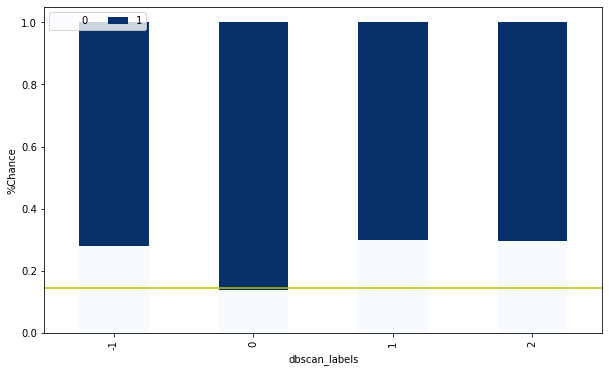

In [77]:
segmended_bar('dbscan_labels')

Na podstawie powyższego wykresu można stwierdzić, że w klastrze 0 prawdopodobieństwo spłacenia pożyczki jest znacznie większe niż w pozostałych klastrach.

In [79]:
dbsc_1 = pd.crosstab(Dane['dbscan_labels'], Dane['loan_status'])
dbsc_1.drop([1, 2], axis = 'index', inplace = True)
dbsc_1

loan_status,0,1
dbscan_labels,,
-1,185,477
0,5258,32763


In [80]:
dbsc_2 = pd.crosstab(Dane['dbscan_labels'], Dane['loan_status'])
dbsc_2.drop([-1, 2], axis = 'index', inplace = True)
dbsc_2

loan_status,0,1
dbscan_labels,,
0,5258,32763
1,306,717


In [81]:
dbsc_3 = pd.crosstab(Dane['dbscan_labels'], Dane['loan_status'])
dbsc_3.drop([-1, 1], axis = 'index', inplace = True)
dbsc_3

loan_status,0,1
dbscan_labels,,
0,5258,32763
2,86,206


In [82]:
test_chi_kwadrat(dbsc_1)
print('\n')
test_chi_kwadrat(dbsc_2)
print('\n')
test_chi_kwadrat(dbsc_3)

p-value wynosi 7.102064197740858e-25
Zmienne zależne (odrzucenie H0)


p-value wynosi 1.720817017593011e-47
Zmienne zależne (odrzucenie H0)


p-value wynosi 3.162366628226721e-14
Zmienne zależne (odrzucenie H0)


Test chi kwadrat potwierdza moje spostrzeżenia. Pożyczkobiorcy przydzieleni do klastra 0 znacznie częściej spłacają pożyczki niż pozostali pożyczkobiorcy.

# Estymacja modeli

In [87]:
auroc = {}
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
RegLog = LogisticRegression()
RegLog.fit(x_train, y_train)
y_p_test = RegLog.predict(x_test)
auroc = pd.DataFrame({'Metoda':['Regresja logistyczna'], 'Score':[RegLog.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test)]}, index={'0'})
dtree_t = DecisionTreeClassifier()
dtree_t.fit(x_train, y_train)
y_p_test = dtree_t.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Drzewo decyzyjne'], 'Score':[dtree_t.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test)]}, index={'1'})
auroc = pd.concat([auroc, tempResultsDf])
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_p_test = rf.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Las losowy'], 'Score':[rf.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'2'})
auroc = pd.concat([auroc, tempResultsDf])
gradient = GradientBoostingClassifier()
gradient.fit(x_train, y_train)
y_p_test = gradient.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Gradient'], 'Score':[gradient.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'3'})
auroc = pd.concat([auroc, tempResultsDf])
ada_boost = AdaBoostClassifier()
ada_boost.fit(x_train, y_train)
y_p_test = ada_boost.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Ada boost'], 'Score':[ada_boost.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'4'})
auroc = pd.concat([auroc, tempResultsDf])
bagging = BaggingClassifier()
bagging.fit(x_train, y_train)
y_p_test = bagging.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Bagging'], 'Score':[bagging.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'5'})
auroc = pd.concat([auroc, tempResultsDf])
kneighbors = KNeighborsClassifier()
kneighbors.fit(x_train, y_train)
y_p_test = kneighbors.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['K-neighbours'], 'Score':[kneighbors.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'6'})
auroc = pd.concat([auroc, tempResultsDf])
xgbc = XGBClassifier(scale_pos_weight = y_train.sum() / (y_train.count() - y_train.sum()))
xgbc.fit(x_train, y_train)
y_p_test = xgbc.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['XGBClassifier'], 'Score':[xgbc.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'7'})
auroc = pd.concat([auroc, tempResultsDf])

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mkraw\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [84]:
auroc_2 = {}
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_final, Y, test_size = 0.2)
dtree_t_pca = DecisionTreeClassifier()
dtree_t_pca.fit(x_train_pca, y_train_pca)
y_p_test = dtree_t_pca.predict(x_test_pca)
auroc_2 = pd.DataFrame({'Metoda':['Drzewo decyzyjne'], 'Score':[dtree_t_pca.score(x_test_pca, y_test_pca)], 'Precision': [precision_score(y_test_pca, y_p_test)], 'Recall': [recall_score(y_test_pca, y_p_test)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'1'})
rf_pca = RandomForestClassifier(n_estimators=100)
rf_pca.fit(x_train_pca, y_train_pca)
y_p_test = rf_pca.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Las losowy'], 'Score':[rf_pca.score(x_test_pca, y_test_pca)], 'Precision': [precision_score(y_test_pca, y_p_test)], 'Recall': [recall_score(y_test_pca, y_p_test)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'2'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
gradient_pca = GradientBoostingClassifier()
gradient_pca.fit(x_train_pca, y_train_pca)
y_p_test = gradient_pca.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Gradient'], 'Score':[gradient_pca.score(x_test_pca, y_test_pca)], 'Precision': [precision_score(y_test_pca, y_p_test)], 'Recall': [recall_score(y_test_pca, y_p_test)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'3'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
ada_boost_pca = AdaBoostClassifier()
ada_boost_pca.fit(x_train_pca, y_train_pca)
y_p_test = ada_boost_pca.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Ada boost'], 'Score':[ada_boost_pca.score(x_test_pca, y_test_pca)], 'Precision': [precision_score(y_test_pca, y_p_test)], 'Recall': [recall_score(y_test_pca, y_p_test)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'4'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
bagging_pca = BaggingClassifier()
bagging_pca.fit(x_train_pca, y_train_pca)
y_p_test = bagging_pca.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Bagging'], 'Score':[bagging_pca.score(x_test_pca, y_test_pca)], 'Precision': [precision_score(y_test_pca, y_p_test)], 'Recall': [recall_score(y_test_pca, y_p_test)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'5'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
kneighbors_pca = KNeighborsClassifier()
kneighbors_pca.fit(x_train_pca, y_train_pca)
y_p_test = kneighbors_pca.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['K-neighbours'], 'Score':[kneighbors_pca.score(x_test_pca, y_test_pca)], 'Precision': [precision_score(y_test_pca, y_p_test)], 'Recall': [recall_score(y_test_pca, y_p_test)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'6'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])

In [88]:
auroc

,Metoda,Score,Precision,Recall,f1,AUROC
0,Regresja logistyczna,0.848875,0.849205,0.999411,0.918206,0.702380
1,Drzewo decyzyjne,0.754750,0.858799,0.850957,0.854860,0.531601
2,Las losowy,0.847250,0.849837,0.996024,0.917141,0.603490
3,Gradient,0.850000,0.850866,0.998233,0.918677,0.748963
4,Ada boost,0.849750,0.850477,0.998527,0.918575,0.746667
5,Bagging,0.823875,0.857162,0.950957,0.901627,0.572050
6,K-neighbours,0.835125,0.851110,0.976583,0.909540,0.545172
7,XGBClassifier,0.848375,0.850270,0.996907,0.917768,0.655904


In [86]:
auroc_2

,Metoda,Score,Precision,Recall,f1,AUROC
1,Drzewo decyzyjne,0.754875,0.863459,0.845838,0.854558,0.536398
2,Las losowy,0.850625,0.853831,0.994861,0.918967,0.653478
3,Gradient,0.851375,0.852432,0.998238,0.919592,0.676216
4,Ada boost,0.850125,0.852778,0.995889,0.918794,0.622041
5,Bagging,0.824000,0.860344,0.946998,0.901594,0.571325
6,K-neighbours,0.837125,0.857662,0.969608,0.910206,0.583831


Na podstawie powyższych tabel wynika, że najlepszym modelem jest gradient (AUROC = 0.748963) utworzonym na podstawie zmiennych przed standaryzacją.

In [91]:
gradient = GradientBoostingClassifier()
gradient.fit(x_train, y_train)
y_p_test = gradient.predict(x_test)
confusion_matrix(y_test, y_p_test)

array([[  22, 1188],
       [  12, 6778]], dtype=int64)

Confusion matrix pokazuje, że model większość 0 (rzeczywistych niespłaconych pożyczek) przydziela do 1 (przewidywanych spłaconych pożyczek). Aby polepszyć jakość modelu utworzę sztuczne dane, które przydzielone zostaną do grupy niespłaconych pożyczek. Wykorzystam do tego algorytm smote.

In [92]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, Y)

In [94]:
auroc_smote = {}
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.2)
RegLog = LogisticRegression()
RegLog.fit(x_train, y_train)
y_p_test = RegLog.predict(x_test)
auroc_smote = pd.DataFrame({'Metoda':['Regresja logistyczna'], 'Score':[RegLog.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test)]}, index={'0'})
dtree_t = DecisionTreeClassifier()
dtree_t.fit(x_train, y_train)
y_p_test = dtree_t.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Drzewo decyzyjne'], 'Score':[dtree_t.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test)]}, index={'1'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_p_test = rf.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Las losowy'], 'Score':[rf.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'2'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])
gradient = GradientBoostingClassifier()
gradient.fit(x_train, y_train)
y_p_test = gradient.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Gradient'], 'Score':[gradient.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'3'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])
ada_boost = AdaBoostClassifier()
ada_boost.fit(x_train, y_train)
y_p_test = ada_boost.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Ada boost'], 'Score':[ada_boost.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'4'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])
bagging = BaggingClassifier()
bagging.fit(x_train, y_train)
y_p_test = bagging.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Bagging'], 'Score':[bagging.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'5'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])
kneighbors = KNeighborsClassifier()
kneighbors.fit(x_train, y_train)
y_p_test = kneighbors.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['K-neighbours'], 'Score':[kneighbors.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'6'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])
xgbc = XGBClassifier(scale_pos_weight = y_train.sum() / (y_train.count() - y_train.sum()))
xgbc.fit(x_train, y_train)
y_p_test = xgbc.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['XGBClassifier'], 'Score':[xgbc.score(x_test, y_test)], 'Precision': [precision_score(y_test, y_p_test)], 'Recall': [recall_score(y_test, y_p_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'7'})
auroc_smote = pd.concat([auroc_smote, tempResultsDf])

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mkraw\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [95]:
auroc_smote

,Metoda,Score,Precision,Recall,f1,AUROC
0,Regresja logistyczna,0.612323,0.610958,0.592861,0.601774,0.612269
1,Drzewo decyzyjne,0.852627,0.862011,0.835456,0.848526,0.853008
2,Las losowy,0.918630,0.865190,0.989485,0.923173,0.926623
3,Gradient,0.906630,0.845097,0.993039,0.913115,0.918449
4,Ada boost,0.899093,0.841316,0.980746,0.905697,0.909442
5,Bagging,0.895141,0.869324,0.927133,0.897298,0.896611
6,K-neighbours,0.767086,0.854560,0.636996,0.729911,0.785325
7,XGBClassifier,0.913947,0.861327,0.984301,0.918717,0.921756


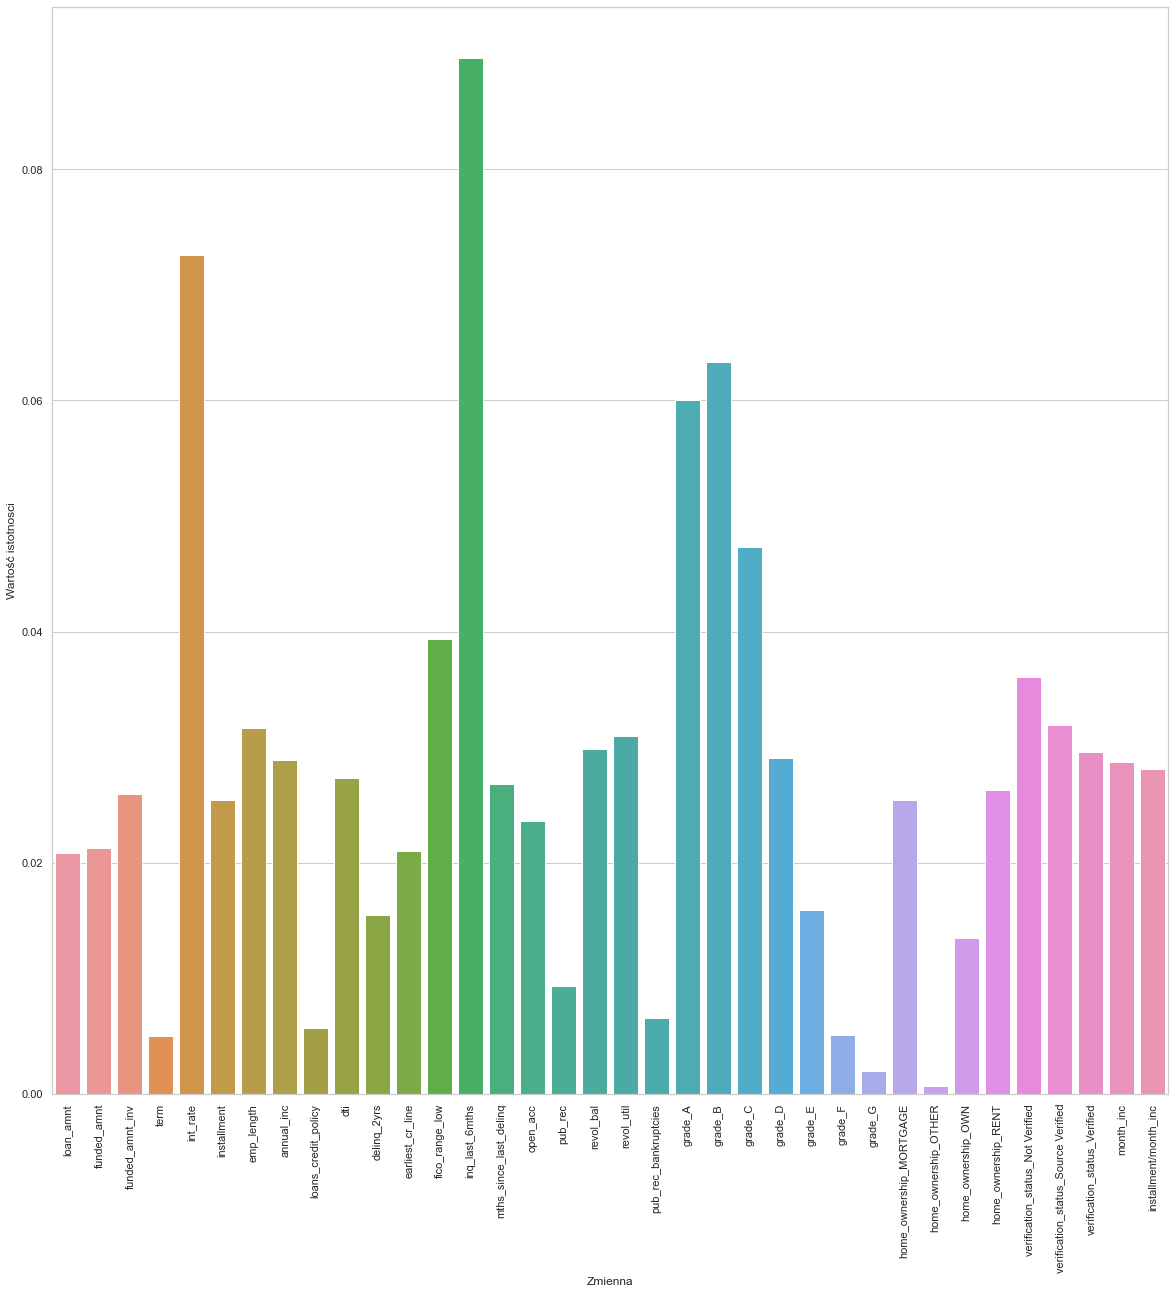

In [98]:
istotnosc = pd.DataFrame({"Zmienna" : X.columns,
              "Wartość istotnosci": rf.feature_importances_})
plt.figure(figsize=(20,20))
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=istotnosc)
for label in ax.get_xticklabels():
    label.set_rotation(90)

Na podstawie powyższego histogramu można stwierdzić, że najbardziej istotną zmienną inq_last_6mths. Pozostałe bardziej istotne zmienne ilościowe to int_rate (oproentowanie) i fico_range_low (wynik fico).

In [97]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_p_test = rf.predict(x_test)
confusion_matrix(y_test, y_p_test)

array([[5872, 1042],
       [  88, 6664]], dtype=int64)

Po skorzystaniu z algorytmu smote wyniki znacznie się poprawiły. Najlepszym okazał się Las Losowy, dla którego wartości score, f1 i AUROC okazały się najwyższe. Confusion matrix pokazuje, że nadal dużo rzeczywistych wartości 0 przydzielane są do 1.